In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [26]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new.csv")

In [27]:
# Define the target variable and numeric columns
target = 'thnoth_name'
numeric_cols_df_0 = df_0.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_0 = df_0.select_dtypes(exclude=[np.number]).columns.tolist()

In [28]:
# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_0 = [col for col in numeric_cols_df_0 if col not in string_cols_df_0]

In [29]:
# Train a RandomForest model to get feature importances
X = df_0[numeric_cols_df_0]
y = df_0[target]

In [30]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [31]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

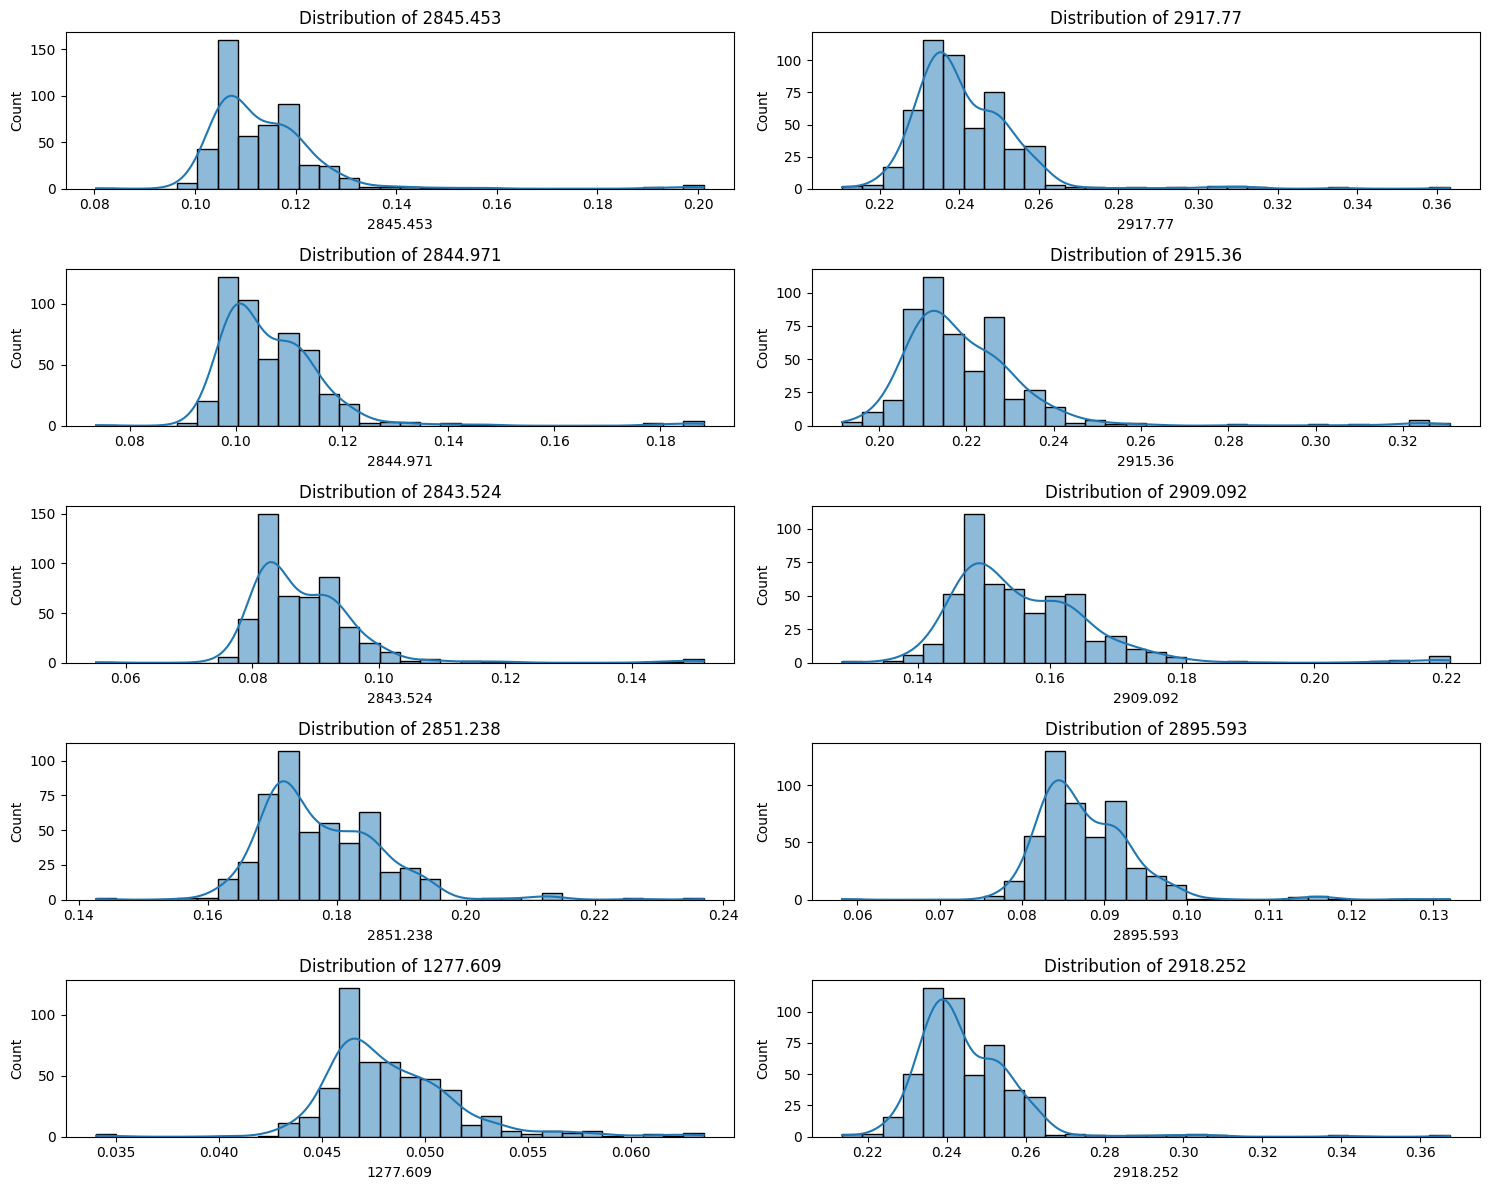

In [32]:
# Plot the distribution of the top 10 most important features
plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df_0[numeric_cols_df_0[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {numeric_cols_df_0[idx]}')
plt.tight_layout()
plt.show()

In [33]:
from scipy import stats

# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 10 important features
top_features = [numeric_cols_df_0[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)


Original Data Shape: (503, 6958)
Cleaned Data Shape: (492, 6958)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the cleaned data into train and test sets
X_cleaned = df_0_cleaned[numeric_cols_df_0]
y_cleaned = df_0_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.5, random_state=42)

# Train the RandomForest model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Analyze accuracy per 'prov_char'
df_0_test_cleaned = df_0_cleaned.loc[X_test.index]
df_0_test_cleaned['predicted'] = y_pred
df_0_test_cleaned['actual'] = y_test.values

prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())
print(prov_char_analysis)


Classification Report:
               precision    recall  f1-score   support

    Non-Thai       0.95      0.70      0.81        80
        Thai       0.87      0.98      0.92       166

    accuracy                           0.89       246
   macro avg       0.91      0.84      0.86       246
weighted avg       0.90      0.89      0.89       246

Confusion Matrix:
 [[ 56  24]
 [  3 163]]
prov_char
BBX    0.454545
CBI    1.000000
CCO    1.000000
CPN    1.000000
JHR    1.000000
KBI    1.000000
KBX    0.181818
KRI    1.000000
KTX    0.913043
NRT    1.000000
NWT    1.000000
PKN    0.875000
PLG    1.000000
PNA    1.000000
PTN    1.000000
RIX    0.777778
RNG    1.000000
SGR    1.000000
SKM    1.000000
SNI    0.967742
SNK    1.000000
SSX    1.000000
STN    1.000000
SUX    0.666667
TRG    0.950000
dtype: float64


C:\Users\pingk\AppData\Local\Temp\ipykernel_23988\4156967957.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())


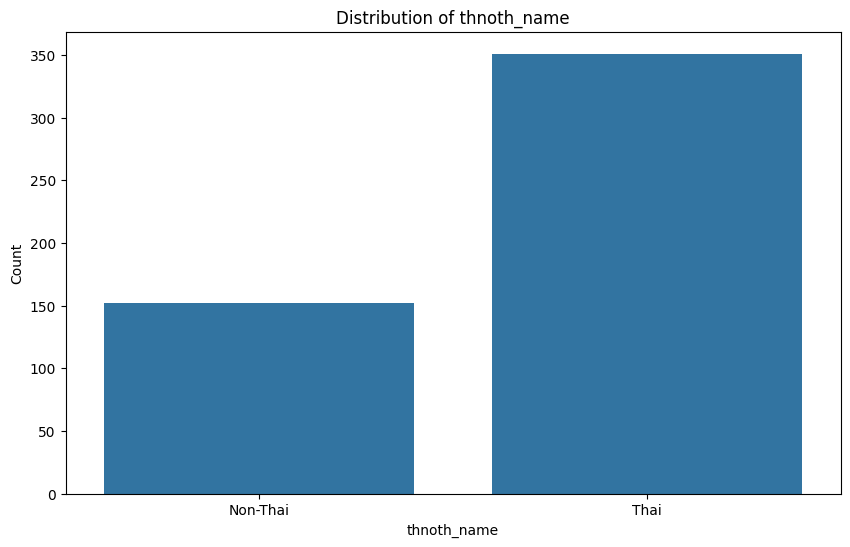

In [35]:
# Create a distribution plot for 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0, x=target)
plt.title('Distribution of thnoth_name')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()

In [36]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_0_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        350
Non-Thai    142
Name: count, dtype: int64


In [37]:
# Separate Thai and Non-Thai samples
df_0_thai = df_0[df_0[target] == 'Thai']
df_0_non_thai = df_0[df_0[target] == 'Non-Thai']

In [38]:
from sklearn.ensemble import IsolationForest

# Identify and remove outliers in Thai samples using Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
yhat = iso.fit_predict(df_0_thai[numeric_cols_df_0])
mask = yhat != -1
df_0_thai_cleaned = df_0_thai[mask]

In [39]:
# Combine the cleaned Thai samples with Non-Thai samples

df_1_cleaned = pd.concat([df_0_thai_cleaned, df_0_non_thai], axis=0).reset_index(drop=True)

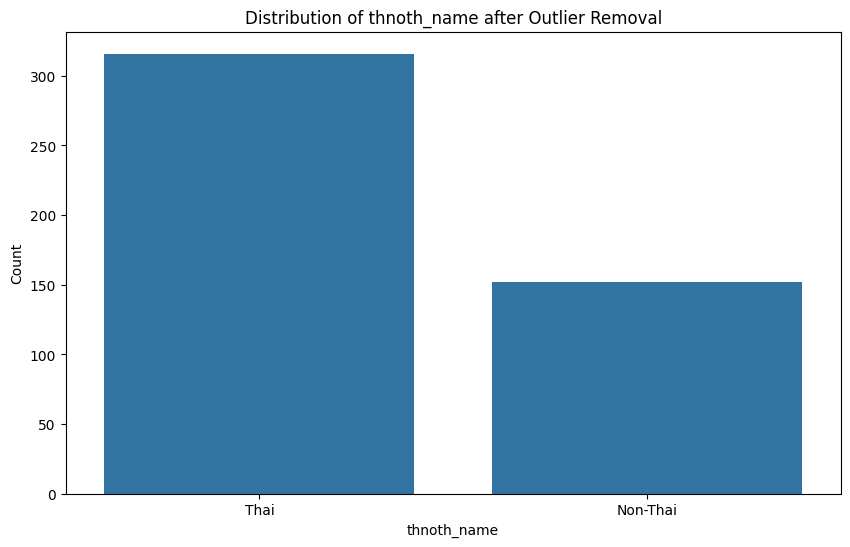

In [40]:
# Plot the distribution of thnoth_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of thnoth_name after Outlier Removal')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


In [41]:
df_1_cleaned.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_now with indo new_cleaned.csv", index=False)

In [42]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_1_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        316
Non-Thai    152
Name: count, dtype: int64


In [43]:
df_2 = df_1_cleaned.copy()

In [44]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Encode 'thnoth_name' column
le_thnoth = LabelEncoder()
df_2['thnoth_name_encoded'] = le_thnoth.fit_transform(df_2['thnoth_name'])

# Encode 'prov_char' column for grouping
le_prov = LabelEncoder()
df_2['prov_char_encoded'] = le_prov.fit_transform(df_2['prov_char'])



# Check the encoding results
print(df_2[['thnoth_name', 'thnoth_name_encoded', 'prov_char', 'prov_char_encoded']].head())


  thnoth_name  thnoth_name_encoded prov_char  prov_char_encoded
0        Thai                    1       CBI                  1
1        Thai                    1       CBI                  1
2        Thai                    1       CBI                  1
3        Thai                    1       CBI                  1
4        Thai                    1       CBI                  1


In [45]:
# Define the features and target
numeric_cols_df_2 = df_2.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_df_2.remove('thnoth_name_encoded')

X = df_2[numeric_cols_df_2]
y = df_2['thnoth_name_encoded']

# Check the shapes of X and y
print(X.shape, y.shape)


(468, 6951) (468,)


In [46]:
from imblearn.under_sampling import RandomUnderSampler

# Get the numeric values for 'Thai' and 'Non-Thai'
thai_label = le_thnoth.transform(['Thai'])[0]
non_thai_label = le_thnoth.transform(['Non-Thai'])[0]

# Apply undersampling to achieve a balanced dataset
rus = RandomUnderSampler(sampling_strategy={thai_label: 152, non_thai_label: 152}, random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

# Define the balanced dataframe
balanced_df_2 = df_2.iloc[rus.sample_indices_].reset_index(drop=True)

# Check the new distribution
print(balanced_df_2['thnoth_name'].value_counts())


thnoth_name
Thai        160
Non-Thai    152
Name: count, dtype: int64


In [50]:
# Reset index of y_balanced and X_balanced to ensure alignment
y_balanced = pd.Series(y_balanced).reset_index(drop=True)
X_balanced = X_balanced.reset_index(drop=True)
balanced_df_2 = balanced_df_2.reset_index(drop=True)
prov_char_encoded = balanced_df_2['prov_char_encoded'].reset_index(drop=True)

In [51]:
from sklearn.ensemble import RandomForestClassifier

# Adjust Class Weights in the RandomForest model
rf = RandomForestClassifier(random_state=42, class_weight={non_thai_label: 1, thai_label: 1.5})

# Train the model on the balanced dataset
rf.fit(X_balanced, y_balanced)

# Check feature importances
print(rf.feature_importances_)


[0.         0.00014103 0.000781   ... 0.         0.         0.0016998 ]


c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `

Mean Accuracy: 0.7172626927980171
Mean Precision: 0.9166666666666666
Mean Recall: 0.7172626927980171
Mean F1-score: 0.7800326182727498
Left out group: ['BBX'], Accuracy: 0.0
Left out group: ['CBI'], Accuracy: 1.0
Left out group: ['CCO'], Accuracy: 1.0
Left out group: ['CPN'], Accuracy: 0.9473684210526315
Left out group: ['JHR'], Accuracy: 1.0
Left out group: ['KBI'], Accuracy: 0.9565217391304348
Left out group: ['KBX'], Accuracy: 0.16666666666666666
Left out group: ['KRI'], Accuracy: 0.5
Left out group: ['KTX'], Accuracy: 0.6097560975609756
Left out group: ['NRT'], Accuracy: 1.0
Left out group: ['NWT'], Accuracy: 1.0
Left out group: ['PKN'], Accuracy: 1.0
Left out group: ['PNA'], Accuracy: 1.0
Left out group: ['PTN'], Accuracy: 0.6666666666666666
Left out group: ['RIX'], Accuracy: 0.5238095238095238
Left out group: ['RNG'], Accuracy: 0.75
Left out group: ['SGR'], Accuracy: 1.0
Left out group: ['SKM'], Accuracy: 0.0
Left out group: ['SNI'], Accuracy: 0.7142857142857143
Left out group: [

c:\Users\pingk\OneDrive - Chulalongkorn University\Documents\mekargit\cpocluster\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


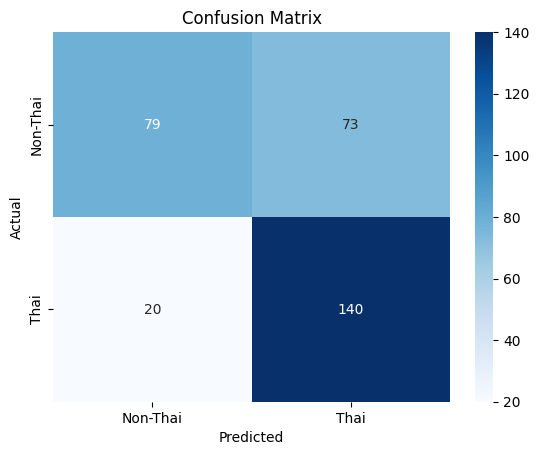

In [52]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize LOGO
logo = LeaveOneGroupOut()

# Arrays to store results
accuracies = []
precisions = []
recalls = []
f1_scores = []
left_out_groups = []
all_y_test = []
all_y_pred = []

# Perform LOGO-CV
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    left_out_groups.append(balanced_df_2['prov_char'].iloc[test_idx].unique().tolist())
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate mean scores
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-score: {mean_f1}')

# Display left out groups and their accuracies
for group, acc in zip(left_out_groups, accuracies):
    print(f'Left out group: {group}, Accuracy: {acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_thnoth.classes_, yticklabels=le_thnoth.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
balanced_df_2.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_rt4_NWIN_CLND_BLNCD.csv", index=False)

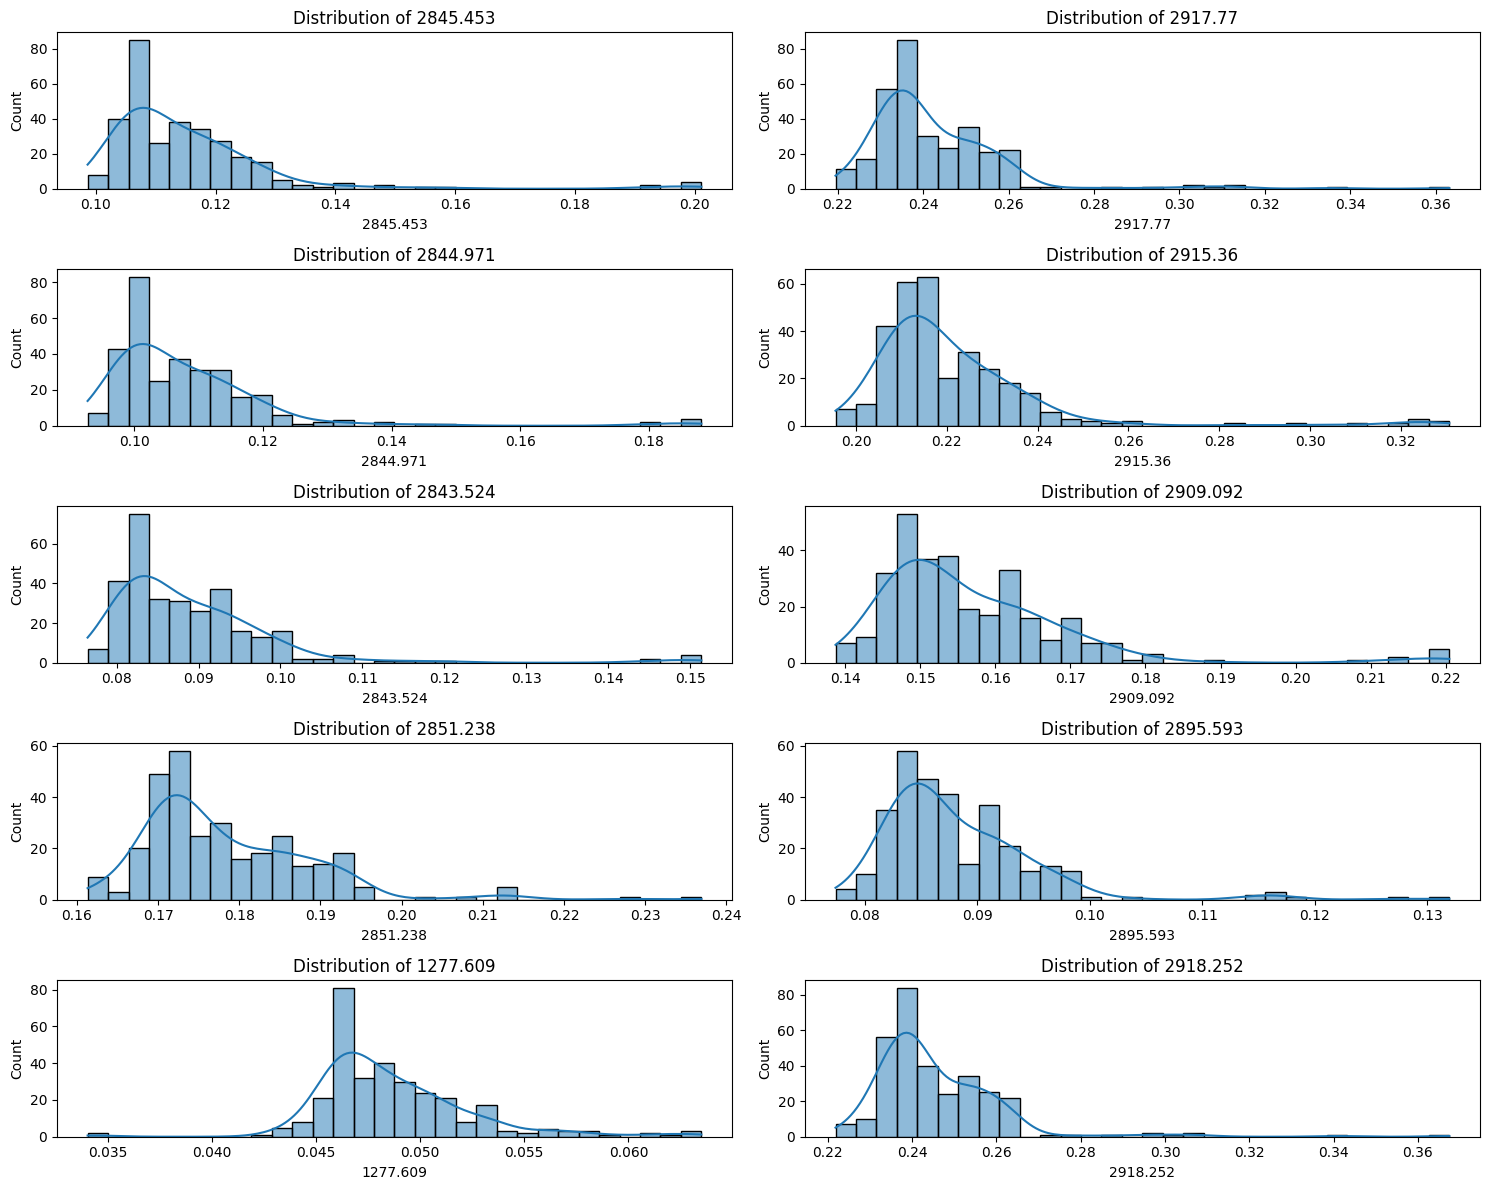

In [59]:
# Plot the distribution of the top 10 most important features
plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    sns.histplot(balanced_df_2[numeric_cols_df_0[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {numeric_cols_df_0[idx]}')
plt.tight_layout()
plt.show()